In [1]:
import pandas as pd
import sqlite3
import os

from pathlib import Path
ROOT = os.getenv('ROOT')

In [2]:
Path(ROOT, "data/currency_rates.db")

WindowsPath('C:/Users/mabid/OneDrive/Desktop/Projects - Ongoing/Airflow_ETL/data/currency_rates.db')

In [3]:
import sqlite3
# Create a sqlite3 database
fetch_data_query = '''
SELECT currency_rates.Currency_Code, currency_names.Currency_Name, currency_rates.Rate, currency_rates.date
FROM currency_rates
JOIN currency_names
ON currency_rates.Currency_Code = currency_names.Currency_Code
'''

conn = sqlite3.connect(Path(ROOT, "data/currency_rates.db"))
c = conn.cursor()

data = pd.read_sql_query(fetch_data_query, conn)

In [4]:
currency_rate_df = data.copy()
currency_rate_df.head()

,currency_code,currency_name,rate,date
0,USD,United States Dollar,1.0000,"Mon, 03 Jun 2024"
1,AED,UAE Dirham,3.6725,"Mon, 03 Jun 2024"
2,AFN,Afghan Afghani,71.2981,"Mon, 03 Jun 2024"
3,ALL,Albanian Lek,92.9346,"Mon, 03 Jun 2024"
4,AMD,Armenian Dram,387.6778,"Mon, 03 Jun 2024"


In [5]:
import matplotlib.pyplot as plt

def process_currency_data(currency_df, currency_code=None, currency_name=None):
    """
    Process the currency DataFrame to prepare it for plotting.
    
    Parameters:
    - currency_df: DataFrame containing currency data.
    - currency_code: Specific currency code to filter the data.
    - currency_name: Specific currency name to filter the data.
    
    Returns:
    - complete_df: Processed DataFrame with filled values and additional columns.
    - currency_code: The currency code used for filtering.
    - currency_name: The currency name used for filtering.
    """
    if currency_code is None and currency_name is None:
        raise ValueError("You must specify either currency_code or currency_name")
    if currency_code is not None and currency_name is not None:
        raise ValueError("You must specify either currency_code or currency_name, not both")

    if currency_code is not None:
        currency_df_sliced = currency_df.loc[currency_df["currency_code"] == currency_code].copy()
    if currency_name is not None:
        currency_df_sliced = currency_df.loc[currency_df["currency_name"].str.contains(currency_name)].copy()

    currency_name = currency_df_sliced["currency_name"].iloc[0]
    currency_code = currency_df_sliced["currency_code"].iloc[0]
    currency_df_sliced["date_standard_format"] = pd.to_datetime(currency_df_sliced["date"])
    currency_df_sliced["in_dollars"] = 1 / currency_df_sliced["rate"]

    first_date = currency_df_sliced["date_standard_format"].min()
    last_date = currency_df_sliced["date_standard_format"].max()

    # Create a complete DataFrame with date range
    complete_dates = pd.date_range(start=first_date, end=last_date, freq="D")
    complete_df = pd.DataFrame({"date_standard_format": complete_dates})
    complete_df = complete_df.merge(currency_df_sliced, on="date_standard_format", how="left")
    complete_df["in_dollars"] = complete_df["in_dollars"].ffill()
    complete_df["date_natural_format"] = complete_df["date_standard_format"].dt.strftime("%d/%m/%Y")
    complete_df["date"] = complete_df["date_standard_format"].dt.strftime("%d %B %Y")
    complete_df[["currency_code", "currency_name", "rate"]] = complete_df[["currency_code", "currency_name", "rate"]].ffill()

    return complete_df, currency_code, currency_name

def plot_currency_evolution(complete_df, currency_code = None, currency_name = None):
    """
    Plot the evolution of the value of a currency in USD over time.
    
    Parameters:
    - complete_df: DataFrame containing processed currency data.
    - currency_code: The currency code used for filtering.
    - currency_name: The currency name used for filtering.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if currency_code is None and currency_name is None:
        raise ValueError("You must specify either currency_code or currency_name")
    if currency_code is not None and currency_name is not None:
        raise ValueError("You must specify either currency_code or currency_name, not both")

    if currency_code is not None:
        complete_df_filtered = complete_df.loc[complete_df["currency_code"] == currency_code].copy()
    if currency_name is not None:
        complete_df_filtered = complete_df.loc[complete_df["currency_name"].str.contains(currency_name)].copy()

    currency_code, currency_name = complete_df_filtered["currency_code"].iloc[0], complete_df_filtered["currency_name"].iloc[0]

    complete_df_filtered.plot(x="date_natural_format", y="in_dollars", title=f"{currency_code} ({currency_name}) value in USD",
                     ylabel="USD", xlabel="date_natural_format", rot=45, marker="o", legend=False, ax=ax)
    
    return complete_df_filtered, currency_code, currency_name

In [6]:
complete_df, currency_code, currency_name = process_currency_data(currency_rate_df, currency_code="EUR")

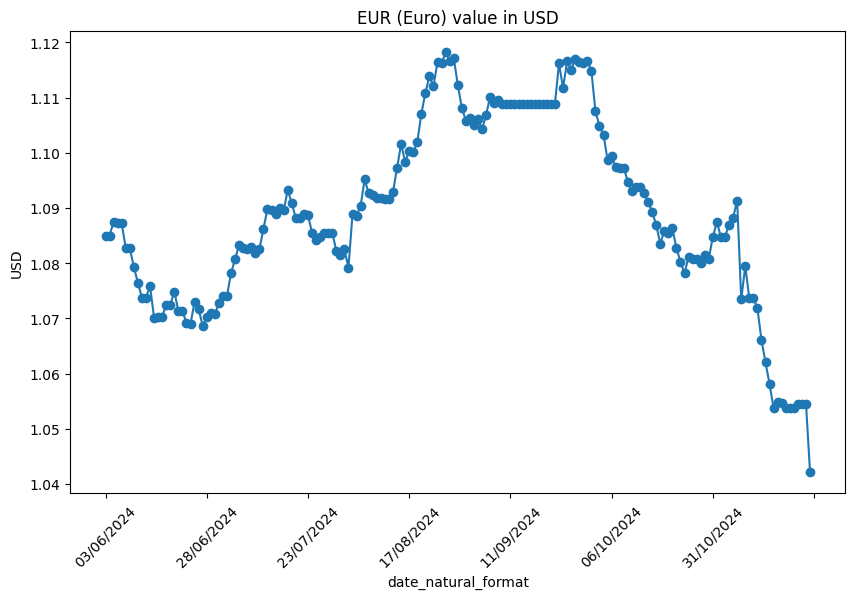

In [7]:
complete_df_for_plotting, currency_code, currency_name = plot_currency_evolution(complete_df, currency_code="EUR")

### Using Plotly

In [ ]:
import plotly.graph_objects as go
import plotly.offline as offline
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1,)

fig.add_trace(
    go.Scatter(
        x=complete_df_for_plotting["date_standard_format"],
        y=complete_df_for_plotting["in_dollars"],
        mode='lines+markers',
        hoverinfo='text',
        text=[f"{currency} : {value:.3f}$" for currency, value in zip(complete_df_for_plotting["date_natural_format"], complete_df_for_plotting["in_dollars"],)],
        name=None,
        showlegend=False
    ),
    row=1,
    col=1
)

fig.update_layout( height=500, width=1400, showlegend=True, title=f"{currency_code} ({currency_name}) currency values in USD", title_x = 0.5)
fig.update_yaxes(title_text="USD ($)", row=1, col=1,)

figure_path = str(Path(ROOT, "figures", f"currency_evolution_EURO.html"))
offline.plot(fig, filename=figure_path)
fig.show()
#fig.write_image(figure_path)

In [16]:
figure_path = str(Path(ROOT, "figures", f"currency_evolution_EURO.html"))
#fig.write_image(figure_path)

In [17]:
figure_path

'C:\\Users\\mabid\\OneDrive\\Desktop\\Projects - Ongoing\\Airflow_ETL\\figures\\currency_evolution_EURO.html'

In [18]:
import plotly
plotly.offline.plot(fig, filename=figure_path)

'C:\\Users\\mabid\\OneDrive\\Desktop\\Projects - Ongoing\\Airflow_ETL\\figures\\currency_evolution_EURO.html'

In [10]:
Path(ROOT, "figures", f"currency_evolution_EUR.png")

WindowsPath('C:/Users/mabid/OneDrive/Desktop/Projects - Ongoing/Airflow_ETL/figures/currency_evolution_EUR.png')